# Benchmark model - Impairment - Sequential Timewise Exploration, calibration, test

This notebook uses as inputs the outputs from the pipeline ('05_preproc_pipeline_1.ipynb' notebook) and performs model calibration and general exploration for the transaction credit events prediction.

In [1]:
import pandas as pd
import numpy as np
import pickle
from os import environ

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scripts_viz.visualization_utils import *
from scripts_ml.models_utils import *

from bokeh.io import show, output_notebook
output_notebook()

import datetime as dt

Loading BokehJS ...

### TRAIN Data import

In [2]:
#importing data
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
prefix_time_seq = 'time_2018-04-30_imp_bg_'
valid_code = '_val_24000_6000_'
trainfile = '_traindata'
testfile = '_testdata'
postfix_time_seq_val = '_190815_645'
postfix_time_seq = '_190812_1547'
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
indexfile = '_fold_indexes'
expname = preproc_folder+"_imp"

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+trainfile+postfix_time_seq+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+testfile+postfix_time_seq+'.pkl') 
[val_X_train, val_y_train, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+trainfile+postfix_time_seq_val+'.pkl') 
[val_X_test, val_y_test, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+testfile+postfix_time_seq_val+'.pkl') 
indexes = pd.read_pickle(datafolder+prefix_time_seq+valid_code+indexfile+postfix_time_seq_val+'.pkl')

In [3]:
#recombining folds for grid search

val_X_all = []
val_y_all = []
indexes_tuples = []

count=0
start_tr=0

for idx in indexes:
    val_X_all.append(val_X_train[idx[0]])
    val_y_all.append(val_y_train[idx[0]])
    if count==0:
        test_idx = np.array(range(0, len(idx[1])))
    else:
        test_idx+=len(idx[1])
    val_X_all.append(val_X_test[test_idx])
    val_y_all.append(val_y_test[test_idx])
    
    
    if count==0:
        start_tst = len(idx[0])
    else:
        start_tr+=add_to_tr
        start_tst=start_tr+len(idx[0])
        
    indexes_tuples.append((np.array(range(start_tr, start_tr+len(idx[0]))), 
                          np.array(range(start_tst, start_tst+len(idx[1])))))
    
    add_to_tr = len(idx[0])+len(idx[1])
    
    count+=1
        

In [4]:
indexes_tuples

[(array([    0,     1,     2, ..., 28098, 28099, 28100]),
  array([28101, 28102, 28103, ..., 34098, 34099, 34100])),
 (array([34101, 34102, 34103, ..., 58098, 58099, 58100]),
  array([58101, 58102, 58103, ..., 64098, 64099, 64100])),
 (array([64101, 64102, 64103, ..., 88098, 88099, 88100]),
  array([88101, 88102, 88103, ..., 94098, 94099, 94100]))]

In [5]:
val_X_all = np.concatenate(val_X_all, axis=0)
val_y_all = np.concatenate(val_y_all, axis=0)

In [6]:
val_X_all.shape

(94101, 35)

In [7]:
val_X_all_df = pd.DataFrame(val_X_all, columns=feature_labels)
val_X_all_df.head()

,currency_Schweizer Franken,currency_Euro,currency_US-Dollar,currency_Britisches Pfund,has_purchase,dd_value_date,cd_lent_c,cd_repaid_c,cd_impaired1_c,cd_pastdue90_c,...,flow_shock_p90,p90_c_node_eff,p90_energy,p90_d_node_flow,flow_shock_p180,p180_d_node_flow,p180_energy,invoice_amount,purchase_amount,invoice_date
0,0.36176,-0.348416,-0.06791,-0.053766,-2.200501,0.328164,-0.601772,-0.458248,-0.173059,-0.081407,...,-0.103529,-0.402551,-0.399377,-0.131966,-0.369063,-0.105271,-0.368598,-0.814780,-2.14725,-4.053529
1,0.36176,-0.348416,-0.06791,-0.053766,-2.200501,0.328164,-0.590850,-0.458248,-0.173059,-0.081407,...,-0.103529,-0.402551,-0.399377,-0.131966,-0.369063,-0.105271,-0.368598,-0.160704,-2.14725,-4.053529
2,0.36176,-0.348416,-0.06791,-0.053766,-2.200501,0.328164,-0.579927,-0.458248,-0.173059,-0.081407,...,-0.103529,-0.402551,-0.399377,-0.131966,-0.369063,-0.105271,-0.368598,-0.518091,-2.14725,-4.053529
3,0.36176,-0.348416,-0.06791,-0.053766,-2.200501,0.328164,-0.601772,-0.458248,-0.173059,-0.081407,...,9.659123,-0.403114,5.054717,-0.131966,5.140608,-0.105271,5.174940,0.874871,-2.14725,-4.053529
4,0.36176,-0.348416,-0.06791,-0.053766,-2.200501,0.328164,-0.601772,-0.458248,-0.173059,-0.081407,...,9.659123,-0.403114,5.054717,-0.131966,5.140608,-0.105271,5.174940,0.367163,-2.14725,-4.053529


In [8]:
val_X_all_df.columns

Index(['currency_Schweizer Franken', 'currency_Euro', 'currency_US-Dollar',
       'currency_Britisches Pfund', 'has_purchase', 'dd_value_date',
       'cd_lent_c', 'cd_repaid_c', 'cd_impaired1_c', 'cd_pastdue90_c',
       'cd_trend_a', 'c_lent_c', 'c_repaid_c', 'c_impaired1_c',
       'c_pastdue90_c', 'c_trend_a', 'd_repaid_c', 'd_impaired1_c',
       'd_pastdue90_c', 'd_trend_a', 'd_we_payment_share', 'flow_shock_imp1',
       'imp_c_node_eff', 'imp_energy', 'imp_d_node_flow', 'flow_shock_p90',
       'p90_c_node_eff', 'p90_energy', 'p90_d_node_flow', 'flow_shock_p180',
       'p180_d_node_flow', 'p180_energy', 'invoice_amount', 'purchase_amount',
       'invoice_date'],
      dtype='object')

In [9]:
val_X_all_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
currency_Schweizer Franken,94101.0,-0.038617,1.046765,-3.942121,0.361760,0.361760,0.361760,0.366428
currency_Euro,94101.0,0.041128,1.053224,-0.353951,-0.348416,-0.348416,-0.348416,4.216556
currency_US-Dollar,94101.0,0.009778,1.072394,-0.085210,-0.081923,-0.067910,-0.067910,14.725393
currency_Britisches Pfund,94101.0,-0.013845,0.917948,-0.053766,-0.053766,-0.053766,-0.019369,51.630093
has_purchase,94101.0,0.003836,0.996749,-2.200501,0.454442,0.454442,0.456040,0.479004
dd_value_date,94101.0,-0.073089,0.866197,-0.197010,-0.197010,-0.197010,-0.011181,89.437126
cd_lent_c,94101.0,0.087790,1.124721,-0.617610,-0.553247,-0.415043,0.137775,4.188148
cd_repaid_c,94101.0,0.090498,1.134398,-0.538928,-0.458248,-0.406714,-0.007415,4.588471
cd_impaired1_c,94101.0,0.026080,1.063469,-0.198426,-0.190321,-0.173059,-0.173059,7.918447
cd_pastdue90_c,94101.0,0.097279,1.341432,-0.183662,-0.097282,-0.081407,-0.081407,12.284026


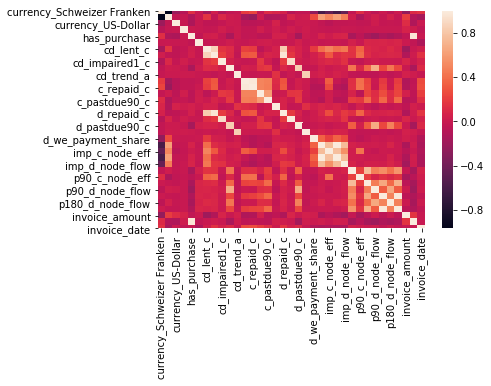

In [10]:
sns.heatmap(val_X_all_df.corr())

### SGD Classifier

In [11]:
#Linear model Stochastic Gradient Descent
sgd_clf = SGDClassifier(random_state=42, max_iter=250, loss='log', tol=0.0001) 
sgd_clf_diag = model_diag_seq(sgd_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 28101 from index 0 to 28100, test on 6000 from 0 to 5999
Fold 1 AUC: 0.8251577933028186
Fold 2: train  on 24000 from index 10101 to 34100, test on 6000 from 6000 to 11999
Fold 2 AUC: 0.821173460321973
Fold 3: train  on 24000 from index 16101 to 40100, test on 6000 from 12000 to 17999
Fold 3 AUC: 0.7112525483566208
Validation AUC 0.781


In [12]:
sgd_clf.fit(X_train, y_train)
y_score_sgd = sgd_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd)
print(cm)
sgd_test_diag = model_oostest(sgd_clf,X_test, y_test)
sgd_test_auc = plot_rocs([sgd_clf_diag, sgd_test_diag], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc)

[[10996    37]
 [  412    73]]
Confusion matrix: 
[[0.99665 0.00335]
 [0.03734 0.00662]]
AUC 0.780


In [13]:
#save_sk_model(sgd_clf, "../data/models/", 'sgd', 'benchmark')

In [14]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# max Number of iterations
max_iter = [100, 180, 200, 250, 300, 320, 350] 
# learning rate
learning_rate = ['constant', 'optimal', 'adaptive']
#eta
eta0 = [0.00001, 0.0001, 0.001, 0.01]
#loss
loss = ['log', 'hinge', 'perceptron']

param_grid = {'max_iter': max_iter,
               'learning_rate': learning_rate,
                  'eta0': eta0,
                  'loss':loss}

sgd = SGDClassifier(tol=0.0001)

sgd_gsearch = GridSearchCV(estimator = sgd, param_grid = param_grid, #param_distributions = sgd_random_grid, 
                           cv = rolling_window_idxs(indexes_tuples),   
                                 verbose=2, n_jobs =7, scoring=scoring, refit='AUC')
# Fit the random search model
sgd_gsearch.fit(val_X_all, val_y_all)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    5.5s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   15.1s
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed:   25.6s
[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed:   36.7s
[Parallel(n_jobs=7)]: Done 756 out of 756 | elapsed:   43.6s finished


GridSearchCV(cv=<generator object rolling_window_idxs at 0x000001CE6BA7EBA0>,
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_...
                                     verbose=0, warm_start=False),
             iid='warn', n_jobs=7,
             param_grid={'eta0': [1e-05, 0.0001, 0.001, 0.01],
                         'learning_rate': ['constant', 'optimal', 'adaptive'],
                         'loss': ['log', 'hinge', 'perceptron'],
                         'max_iter': [100, 180, 200, 250, 300, 320, 3

In [16]:
sgd_gsearch.best_params_

{'eta0': 0.001, 'learning_rate': 'constant', 'loss': 'log', 'max_iter': 320}

In [17]:
#Linear model Stochastic Gradient Descent
sgd_gs = SGDClassifier(random_state=42, max_iter=320, loss='log', learning_rate='constant', eta0=0.001, tol=0.0001) 
sgd_gs_diag = model_diag_seq(sgd_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 28101 from index 0 to 28100, test on 6000 from 0 to 5999
Fold 1 AUC: 0.8251577933028186
Fold 2: train  on 24000 from index 10101 to 34100, test on 6000 from 6000 to 11999
Fold 2 AUC: 0.821173460321973
Fold 3: train  on 24000 from index 16101 to 40100, test on 6000 from 12000 to 17999
Fold 3 AUC: 0.7112525483566208
Validation AUC 0.781


In [18]:
sgd_gs.fit(X_train, y_train)
y_score_sgd_gs = sgd_gs.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd_gs)
print(cm)
sgd_test_diag_gs = model_oostest(sgd_gs,X_test, y_test)
sgd_test_auc_gs = plot_rocs([sgd_gs_diag, sgd_test_diag_gs], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc_gs)

[[11002    31]
 [  439    46]]
Confusion matrix: 
[[0.99719 0.00281]
 [0.03979 0.00417]]
AUC 0.773


### Random Forest Classifier

In [19]:
#random forest - benchmark
n_estimators = 200
max_leaf_nodes = 40
rf_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                               max_leaf_nodes=max_leaf_nodes,
                               class_weight="balanced",
                               n_jobs=7)

rf_clf_diag = model_diag_seq(rf_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 28101 from index 0 to 28100, test on 6000 from 0 to 5999
Fold 1 AUC: 0.9760407130811853
Fold 2: train  on 24000 from index 10101 to 34100, test on 6000 from 6000 to 11999
Fold 2 AUC: 0.9616357635310423
Fold 3: train  on 24000 from index 16101 to 40100, test on 6000 from 12000 to 17999
Fold 3 AUC: 0.7763377540365258
Validation AUC 0.914


In [20]:
rf_clf.fit(X_train, y_train)
y_score_rf = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf)
print(cm)
rf_test_diag = model_oostest(rf_clf,X_test, y_test)
rf_test_auc = plot_rocs([rf_clf_diag, rf_test_diag], p_width=600, p_height=600, model_appendix=['RF - seq_valid','RF - test'])
show(rf_test_auc)

[[10123   910]
 [   94   391]]
Confusion matrix: 
[[0.91752 0.08248]
 [0.00852 0.03544]]
AUC 0.954


### Randomized Grid Search

In [21]:
# Number of trees in random forest
n_estimators = [150, 180, 200, 250, 280, 300, 350] 
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 10, 20]
# Maximum number of levels in tree
max_depth = [100,200, None]
#Max leaf nodes
max_leaf_nodes = [10,20,40,60]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [22]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 80, 
                               cv = rolling_window_idxs(indexes_tuples), 
                               verbose=2, random_state=42, n_jobs =6, refit='AUC', scoring=scoring)
# Fit the random search model
rf_random.fit(val_X_all, val_y_all)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   51.4s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 240 out of 240 | elapsed:  7.4min finished


RandomizedSearchCV(cv=<generator object rolling_window_idxs at 0x000001CE6C7458E0>,
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_f...
                   param_distributions={'bootstrap': [True, False],
    

In [23]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 40,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [24]:
# Number of trees in random forest
n_estimators = [280, 300, 350] 
# Number of features to consider at every split
max_features = ['sqrt', 20]
# Maximum number of levels in tree
max_depth = [None, 200]
#Max leaf nodes
max_leaf_nodes = [40,60]
# Minimum number of samples required to split a node
min_samples_split = [2,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [25]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = rolling_window_idxs(indexes_tuples),   
                                 verbose=2, n_jobs =7, scoring=scoring, refit='AUC')
# Fit the random search model
rf_grid.fit(val_X_all, val_y_all)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   37.5s
[Parallel(n_jobs=7)]: Done 144 out of 144 | elapsed:  5.8min finished


GridSearchCV(cv=<generator object rolling_window_idxs at 0x000001CE6C745AF0>,
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fractio...
                                              warm_start=False),
             iid='warn', n_jobs=7,
             param_grid={'bootstrap': [True], 'max_depth': [None, 200],
                         'max_features': ['sqrt', 20],
         

In [26]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 200,
 'max_features': 'sqrt',
 'max_leaf_nodes': 60,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 350}

In [27]:
#optimized params 
rf_opt = {'n_estimators': 350,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 60,
 'max_features': 'sqrt',
 'max_depth': 200,
 'bootstrap': True}

In [28]:
#random_forest from rand
n_estimators=rf_opt['n_estimators']
min_samples_split=rf_opt['min_samples_split']
min_samples_leaf=rf_opt['min_samples_leaf']
max_leaf_nodes=rf_opt['max_leaf_nodes']
max_features=rf_opt['max_features']
max_depth=rf_opt['max_depth']
bootstrap=rf_opt['bootstrap']




rf_opt_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                                max_features=max_features,
                                min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               class_weight="balanced", bootstrap=bootstrap,
                               n_jobs=7)

rf_opt_diag = model_diag_seq(rf_opt_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 28101 from index 0 to 28100, test on 6000 from 0 to 5999
Fold 1 AUC: 0.9652914960250543
Fold 2: train  on 24000 from index 10101 to 34100, test on 6000 from 6000 to 11999
Fold 2 AUC: 0.9537730107679733
Fold 3: train  on 24000 from index 16101 to 40100, test on 6000 from 12000 to 17999
Fold 3 AUC: 0.7804465826905571
Validation AUC 0.905


In [29]:
rf_opt_clf.fit(X_train, y_train)
y_score_rf_opt = rf_opt_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf_opt)
print(cm)
rf_opt_test_diag = model_oostest(rf_opt_clf,X_test, y_test)
rf_opt_test_auc = plot_rocs([rf_opt_diag, rf_opt_test_diag], p_width=600, p_height=600, model_appendix=['RF - val_seq','RF - test'])
show(rf_opt_test_auc)

[[11033     0]
 [  478     7]]
Confusion matrix: 
[[1.      0.     ]
 [0.04332 0.00063]]
AUC 0.964
